# Lecture 16
Statistical Rethinking Winter 2022 lecture 16. The slide numbers are in reference to [this link](https://speakerdeck.com/rmcelreath/statistical-rethinking-2022-lecture-16).

In [1]:
import warnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats
import pytensor.tensor as pt

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "waic"

In [3]:
Dmat = pd.read_csv("../Data/islandsDistMatrix.csv", sep=",", index_col=0)
Dmat

,Ml,Ti,SC,Ya,Fi,Tr,Ch,Mn,To,Ha
Malekula,0.000,0.475,0.631,4.363,1.234,2.036,3.178,2.794,1.860,5.678
Tikopia,0.475,0.000,0.315,4.173,1.236,2.007,2.877,2.670,1.965,5.283
Santa Cruz,0.631,0.315,0.000,3.859,1.550,1.708,2.588,2.356,2.279,5.401
Yap,4.363,4.173,3.859,0.000,5.391,2.462,1.555,1.616,6.136,7.178
Lau Fiji,1.234,1.236,1.550,5.391,0.000,3.219,4.027,3.906,0.763,4.884
Trobriand,2.036,2.007,1.708,2.462,3.219,0.000,1.801,0.850,3.893,6.653
Chuuk,3.178,2.877,2.588,1.555,4.027,1.801,0.000,1.213,4.789,5.787
Manus,2.794,2.670,2.356,1.616,3.906,0.850,1.213,0.000,4.622,6.722
Tonga,1.860,1.965,2.279,6.136,0.763,3.893,4.789,4.622,0.000,5.037
Hawaii,5.678,5.283,5.401,7.178,4.884,6.653,5.787,6.722,5.037,0.000


In [4]:
dk = pd.read_csv("../Data/Kline2.csv", sep=",")

Nsociety = dk.shape[0]
society = np.arange(Nsociety)
total_tools = dk.total_tools.values

Dmat = Dmat.values
Dmatsq = np.power(Dmat, 2)

P = stats.zscore(np.log(dk.population))
P = P + np.abs(P.min()) + 0.1  # must be > 0, see chp 11

dk

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.003065
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.313220
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.188689
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.474494
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.909235
5,Trobriand,8000,high,19,4.0,-8.7,150.9,-29.1,8.987197
6,Chuuk,9200,high,40,3.8,7.4,151.6,-28.4,9.126959
7,Manus,13000,low,28,6.6,-2.1,146.9,-33.1,9.472705
8,Tonga,17500,high,55,5.4,-21.2,-175.2,4.8,9.769956
9,Hawaii,275000,low,71,6.6,19.9,-155.6,24.4,12.524526


## Slide 28


$$ k_{i,j} =\eta^2  \mathrm{exp}\left( - \rho^2 \delta_{i,j}^2 \right )$$
$$\eta^2 \sim Exponential(2)$$
$$\rho^2 \sim Exponential(0.5)$$

[Text(0, 0.5, 'covariance'),
 Text(0.5, 0, 'distance (thousand km)'),
 (0.0, 7.0),
 (0.0, 2.0)]

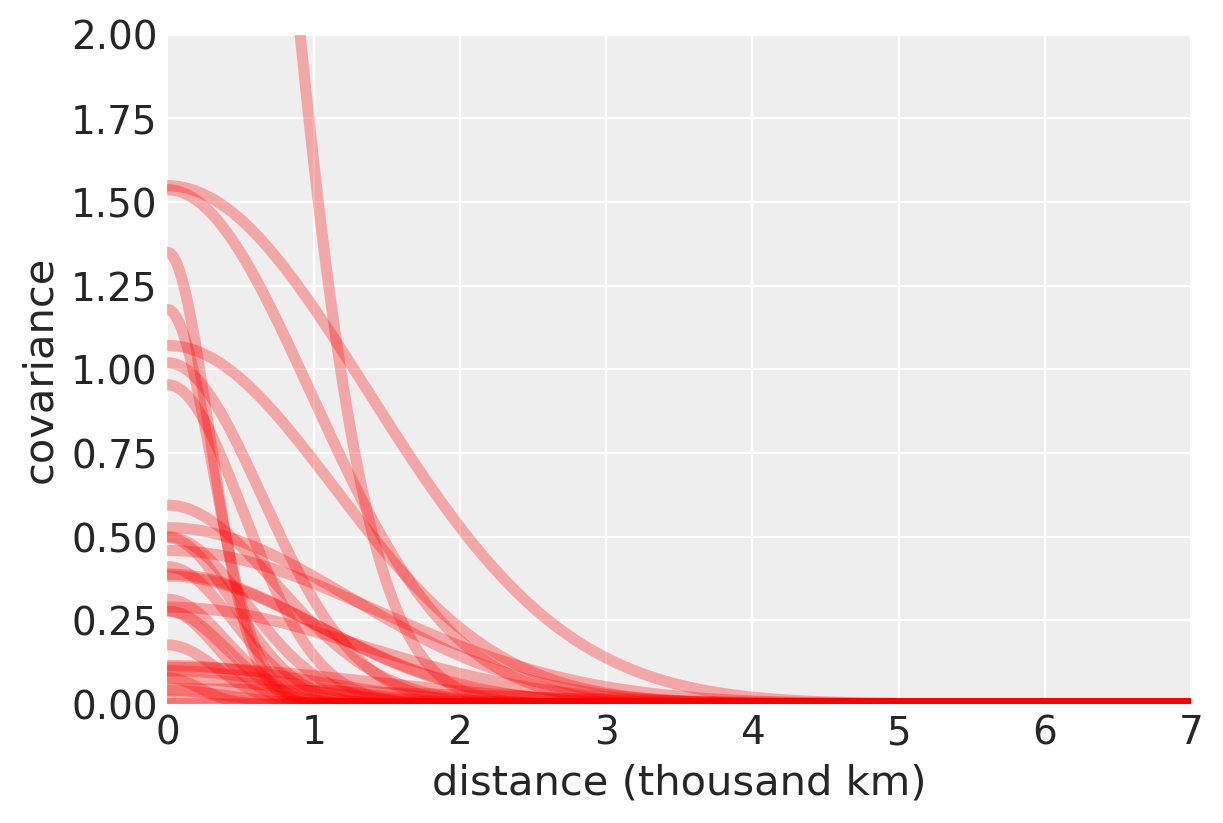

In [5]:
xrange=np.linspace(0,10,500)
f,axs=plt.subplots(figsize=(6,4))
n=30
etasq=stats.expon(scale=1/2).rvs(n)
rhosq=stats.expon(scale=1/0.5).rvs(n)
for i in range(30):
    axs.plot(xrange,etasq[i]*np.exp(-rhosq[i]*xrange**2),lw=4,color="r",alpha=0.3)
axs.set(ylabel="covariance",xlabel="distance (thousand km)",xlim=(0,7),ylim=(0,2))

# slide30

$$ T_{i} \sim Poisson(\lambda_{i})$$
$$log \lambda_{i} = \bar{\alpha} + \alpha_{S[i]}$$

$$\begin{bmatrix}\alpha_{1} \\ \alpha_{1} \\ . \\ . \\ . \\ \alpha_{10}\\\end{bmatrix}\sim MVNormal \left( \begin{bmatrix}0 \\ 0\\ . \\ . \\ . \\ 0\\\end{bmatrix}, \mathrm{K}\right)$$

$$ k_{i,j} =\eta^2  \mathrm{exp}\left( - \rho^2 \delta_{i,j}^2 \right )$$
$$\bar{\alpha} \sim Normal(3,0.5)$$
$$\eta^2 \sim Exponential(2)$$
$$\rho^2 \sim Exponential(0.5)$$

## Method 1

**Note:** Method 1 utilizes an exact code translation from the lecture to PYMC. If you prefer to use PYMC's gp module, you can refer to Method 2. 

In [6]:
with pm.Model() as mTdist0:
    a_bar=pm.Normal("a_bar",3,0.5)
    etasq=pm.Exponential("etasq",2.0)
    rhosq=pm.Exponential("rhosq",0.5)
    K=etasq* pt.exp(-rhosq*Dmatsq)+pt.diag([.01]*Nsociety)
    a=pm.MvNormal("a",0.0,K)
    lam=pm.math.exp(a_bar+a[society])
    T=pm.Poisson("T",lam,observed=total_tools)
    idata_mTdist0=pm.sample(4000,chains=4,cores=2,target_accept=0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [a_bar, etasq, rhosq, a]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 74 seconds.


In [7]:
az.summary(idata_mTdist0)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,3.477,0.254,3.078,3.861,0.006,0.004,1844.0,2052.0,1.0
a[0],-0.655,0.310,-1.135,-0.166,0.006,0.004,2650.0,2530.0,1.0
a[1],-0.411,0.295,-0.877,0.045,0.006,0.005,2293.0,2673.0,1.0
a[2],-0.363,0.300,-0.834,0.103,0.007,0.005,2200.0,2913.0,1.0
a[3],0.256,0.285,-0.210,0.681,0.006,0.005,2246.0,2487.0,1.0
a[4],0.035,0.289,-0.401,0.501,0.006,0.006,2257.0,2554.0,1.0
a[5],-0.461,0.298,-0.926,0.004,0.006,0.004,2615.0,3213.0,1.0
a[6],0.181,0.290,-0.273,0.626,0.006,0.005,2277.0,2587.0,1.0
a[7],-0.154,0.298,-0.611,0.315,0.006,0.005,2349.0,2721.0,1.0
a[8],0.463,0.285,0.015,0.902,0.006,0.005,2141.0,2576.0,1.0


In [8]:
with pm.Model() as mTdist:
    a_bar=pm.Normal("a_bar",3,0.5)
    etasq=pm.Exponential("etasq",2.0)
    rhosq=pm.Exponential("rhosq",0.5)   
    ls_inv  = pm.Deterministic("ls_inv",2*rhosq)
    cov_func=etasq*pm.gp.cov.ExpQuad(input_dim=1,ls_inv=ls_inv)
    gp=pm.gp.Latent(cov_func=cov_func)
    a=gp.prior("a", X=Dmat)
    lam=pm.math.exp(a_bar+a[society])
    T=pm.Poisson("T",lam,observed=total_tools)
    idata_mTdist=pm.sample(4000,chains=4,cores=2,target_accept=0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [a_bar, etasq, rhosq, a_rotated_]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 80 seconds.


In [9]:
az.summary(idata_mTdist)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,3.393,0.206,3.083,3.722,0.003,0.002,3759.0,4888.0,1.0
a_rotated_[0],-1.241,0.577,-2.139,-0.317,0.008,0.006,5264.0,6679.0,1.0
a_rotated_[1],-0.416,0.551,-1.280,0.412,0.012,0.009,2604.0,1410.0,1.0
a_rotated_[2],-0.187,0.566,-1.100,0.664,0.006,0.005,8931.0,7825.0,1.0
a_rotated_[3],0.584,0.427,-0.103,1.258,0.006,0.004,5104.0,8504.0,1.0
a_rotated_[4],0.147,0.470,-0.594,0.859,0.007,0.005,5080.0,4709.0,1.0
a_rotated_[5],-0.585,0.515,-1.390,0.221,0.007,0.005,5901.0,7931.0,1.0
a_rotated_[6],0.445,0.444,-0.205,1.175,0.007,0.005,4864.0,4628.0,1.0
a_rotated_[7],-0.192,0.482,-0.927,0.568,0.006,0.006,5895.0,5739.0,1.0
a_rotated_[8],1.460,0.607,0.538,2.380,0.010,0.007,4106.0,2416.0,1.0


# slide 35

In [10]:
with pm.Model() as mTDP:
    a_bar=pm.Normal("a_bar",3,1.5)
    b=pm.Exponential("b",1.0)
    g=pm.Exponential("g",1.0)
    etasq=pm.Exponential("etasq",2.0)
    rhosq=pm.Exponential("rhosq",0.5)
    Pop=pm.Data("Pop",P)
    ## since the function takes ExpQuad in Pymc takes ls or ls_inv; c
    ls_inv = pm.Deterministic("ls_inv",2*rhosq)

    cov= etasq * pm.gp.cov.ExpQuad(input_dim=1,ls_inv=ls_inv)
    gp=pm.gp.Latent(cov_func=cov)
    a=gp.prior("a", X=Dmat)
    lam=(a_bar * P.values ** b / g) * pt.exp(a[society])
    T=pm.Poisson("T",lam,observed=total_tools)
    idata_mTDP=pm.sample(4000,chains=4,cores=2,target_accept=0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [a_bar, b, g, etasq, rhosq, a_rotated_]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 207 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.


In [11]:
az.summary(idata_mTDP)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,3.669,1.322,1.443,5.678,0.016,0.011,6444.0,4503.0,1.0
a_rotated_[0],0.085,0.875,-1.394,1.417,0.010,0.007,7297.0,9389.0,1.0
a_rotated_[1],0.115,0.722,-1.045,1.250,0.008,0.006,8681.0,10084.0,1.0
a_rotated_[2],-0.460,0.718,-1.580,0.671,0.010,0.007,5620.0,3577.0,1.0
a_rotated_[3],0.679,0.584,-0.211,1.632,0.006,0.005,10344.0,9563.0,1.0
a_rotated_[4],-0.135,0.632,-1.123,0.866,0.007,0.007,8825.0,7187.0,1.0
a_rotated_[5],-0.997,0.724,-2.126,0.104,0.012,0.008,4372.0,2821.0,1.0
a_rotated_[6],0.136,0.603,-0.836,1.051,0.006,0.006,9992.0,6869.0,1.0
a_rotated_[7],-0.678,0.688,-1.795,0.318,0.010,0.007,5113.0,3460.0,1.0
a_rotated_[8],1.045,0.775,-0.092,2.276,0.015,0.011,3117.0,2091.0,1.0


# Pause

In [12]:
Primates301 = pd.read_csv("../Data/Primates301.csv", sep=";")

In [13]:
dpymc = Primates301.dropna(subset=["group_size", "body", "brain"])
spp_obs = dpymc["name"]
dpymc

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.0,40.00,NaN,106.15,276.0,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.0,7.40,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.0,8.90,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.0,7.40,NaN,NaN,NaN,NaN,NaN
5,Alouatta_palliata,Alouatta,palliata,NaN,6,3,3.0,79.0,49.88,6250.0,13.10,185.42,495.60,300.0,1578.42,681.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,Trachypithecus_obscurus,Trachypithecus,obscurus,NaN,295,67,0.0,6.0,62.12,7056.0,10.00,146.63,362.93,300.0,NaN,509.56
295,Trachypithecus_phayrei,Trachypithecus,phayrei,NaN,296,67,0.0,16.0,72.84,7475.0,12.90,180.61,305.87,NaN,NaN,486.48
296,Trachypithecus_pileatus,Trachypithecus,pileatus,NaN,297,67,0.0,5.0,103.64,11794.0,8.50,NaN,NaN,NaN,NaN,NaN
298,Trachypithecus_vetulus,Trachypithecus,vetulus,NaN,299,67,0.0,2.0,61.29,6237.0,8.35,204.72,245.78,276.0,1113.70,450.50


This is copied from exactly from the chapter Notes

In [14]:
N_spp = len(dpymc)
M = stats.zscore(np.log(dpymc.body.values))
B_ = stats.zscore(np.log(dpymc.brain.values))
G = stats.zscore(np.log(dpymc.group_size.values))
Imat = np.diag(np.ones(N_spp))

# Slide 70

In [15]:
with pm.Model() as mBMG0:
    a = pm.Normal("a", 0.0,1.0)
    bM = pm.Normal("bM",0.0,0.5)
    bG = pm.Normal("bG",0.0,0.5)
    sigma = pm.Exponential("sigma",1.0)
    mu = a + bM * M + bG * G
    B = pm.Normal("B",mu,sigma,observed = B_)
    trace_mBMG0 = pm.sample(4000,chains=4,cores=2,target_accept=0.98)
az.summary(trace_mBMG0,round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [a, bM, bG, sigma]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 7 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.02,-0.03,0.03,0.0,0.0,11084.12,10073.88,1.0
bM,0.89,0.02,0.85,0.93,0.0,0.0,9891.26,10838.12,1.0
bG,0.12,0.02,0.09,0.16,0.0,0.0,9635.22,9363.74,1.0
sigma,0.22,0.01,0.20,0.24,0.0,0.0,11549.71,9669.43,1.0


In [33]:
with pm.Model() as mBMG:
    a = pm.Normal("a", 0.0, 1.0)
    bM = pm.Normal("bM", 0.0, 0.5)
    bG = pm.Normal("bG", 0.0, 0.5)
    sigma_sq = pm.Exponential("sigma_sq", 1.0)

    mu = a + bM * M + bG * G
    K = Imat * sigma_sq
    B = pm.MvNormal("B", mu, cov=K, observed=B_)

    trace_mBMG = pm.sample(cores=2)
az.summary(trace_mBMG, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, bG, sigma_sq]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 442 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.00,0.02,-0.03,0.03,0.0,0.0,2318.04,1581.09,1.00
bM,0.89,0.02,0.86,0.93,0.0,0.0,1758.74,1291.24,1.00
bG,0.12,0.02,0.09,0.16,0.0,0.0,1775.83,1715.71,1.00
sigma_sq,0.05,0.01,0.04,0.06,0.0,0.0,1839.05,1475.33,1.01


In [17]:

Dmat = pd.read_csv("../Data/Primates301_distance_matrix.csv", index_col=0)


In [18]:
# scale and reorder distance matrix
Dmat_ord = (Dmat.loc[spp_obs, spp_obs] / Dmat.loc[spp_obs, spp_obs].max()).values

In [19]:
Dmat.loc[spp_obs, spp_obs]

,Allenopithecus_nigroviridis,Alouatta_belzebul,Alouatta_caraya,Alouatta_guariba,Alouatta_palliata,Alouatta_pigra,Alouatta_seniculus,Aotus_azarai,Aotus_trivirgatus,Arctocebus_calabarensis,...,Tarsius_syrichta,Theropithecus_gelada,Trachypithecus_cristatus,Trachypithecus_geei,Trachypithecus_johnii,Trachypithecus_obscurus,Trachypithecus_phayrei,Trachypithecus_pileatus,Trachypithecus_vetulus,Varecia_variegata_variegata
Allenopithecus_nigroviridis,0.000000,93.623643,93.623642,93.623642,93.623643,93.623643,93.623642,93.623643,93.623642,146.006036,...,137.680065,29.750357,42.820750,42.820749,42.820749,42.820750,42.820750,42.820749,42.820749,146.006035
Alouatta_belzebul,93.623643,0.000000,7.776433,9.138493,6.842844,6.842844,7.776433,42.642602,42.642601,146.006037,...,137.680066,93.623644,93.623645,93.623644,93.623644,93.623645,93.623645,93.623644,93.623644,146.006036
Alouatta_caraya,93.623642,7.776433,0.000000,9.138492,7.776433,7.776433,5.772942,42.642601,42.642600,146.006036,...,137.680065,93.623643,93.623644,93.623643,93.623643,93.623644,93.623644,93.623643,93.623643,146.006035
Alouatta_guariba,93.623642,9.138493,9.138492,0.000000,9.138493,9.138493,9.138492,42.642601,42.642600,146.006036,...,137.680065,93.623643,93.623644,93.623643,93.623643,93.623644,93.623644,93.623643,93.623643,146.006035
Alouatta_palliata,93.623643,6.842844,7.776433,9.138493,0.000000,3.164340,7.776433,42.642602,42.642601,146.006037,...,137.680066,93.623644,93.623645,93.623644,93.623644,93.623645,93.623645,93.623644,93.623644,146.006036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trachypithecus_obscurus,42.820750,93.623645,93.623644,93.623644,93.623645,93.623645,93.623644,93.623645,93.623644,146.006038,...,137.680067,42.820751,8.030014,22.922755,22.922755,0.000000,10.505974,22.922755,22.922755,146.006037
Trachypithecus_phayrei,42.820750,93.623645,93.623644,93.623644,93.623645,93.623645,93.623644,93.623645,93.623644,146.006038,...,137.680067,42.820751,10.505974,22.922755,22.922755,10.505974,0.000000,22.922755,22.922755,146.006037
Trachypithecus_pileatus,42.820749,93.623644,93.623643,93.623643,93.623644,93.623644,93.623643,93.623644,93.623643,146.006037,...,137.680066,42.820750,22.922755,0.871438,9.346964,22.922755,22.922755,0.000000,6.987532,146.006036
Trachypithecus_vetulus,42.820749,93.623644,93.623643,93.623643,93.623644,93.623644,93.623643,93.623644,93.623643,146.006037,...,137.680066,42.820750,22.922755,6.987532,9.346964,22.922755,22.922755,6.987532,0.000000,146.006036


# Slide 82

**Note:**  there is a PYMC's Gp class which leverages marginal likelihood and may potentially offer improved efficiency (see Chapter 14 PYMC conversion); but I will be using the approach which is mentioned in the lectures itself mostly because of two reasons; one its relevant to the lecture second, as of now I could not match the estimates for etasq with the lecture's estimate using Pymc's GP class. (I will update this repo once I am able to find the solution)

In [25]:
with pm.Model() as mB_OU:
    a = pm.Normal("a", 0.0, 1.0)
    etasq_ = pm.Normal("etasq_",1,0.25)
    rho_ = pm.Normal("rho_",3,0.25)
    
    etasq = pm.Deterministic("etasq",pm.math.abs(etasq_))
    rho = pm.Deterministic("rho",pm.math.abs(rho_))
    mu = a + 0*M
    K = etasq * pt.math.exp(-rho*Dmat_ord) +pt.diag([.01]*N_spp)
    B = pm.MvNormal("B", mu=mu,cov=K,observed = B_)   
    trace_mB_OU = pm.sample(cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, etasq_, rho_]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 256 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [31]:
az.summary(trace_mB_OU)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.594,0.265,-1.006,-0.169,0.006,0.005,1886.0,1418.0,1.01
etasq_,0.415,0.056,0.321,0.494,0.001,0.001,1701.0,1476.0,1.00
rho_,2.364,0.254,1.937,2.748,0.006,0.004,1708.0,1389.0,1.00
etasq,0.415,0.056,0.321,0.494,0.001,0.001,1701.0,1476.0,1.00
rho,2.364,0.254,1.937,2.748,0.006,0.004,1708.0,1389.0,1.00


# Slide 84

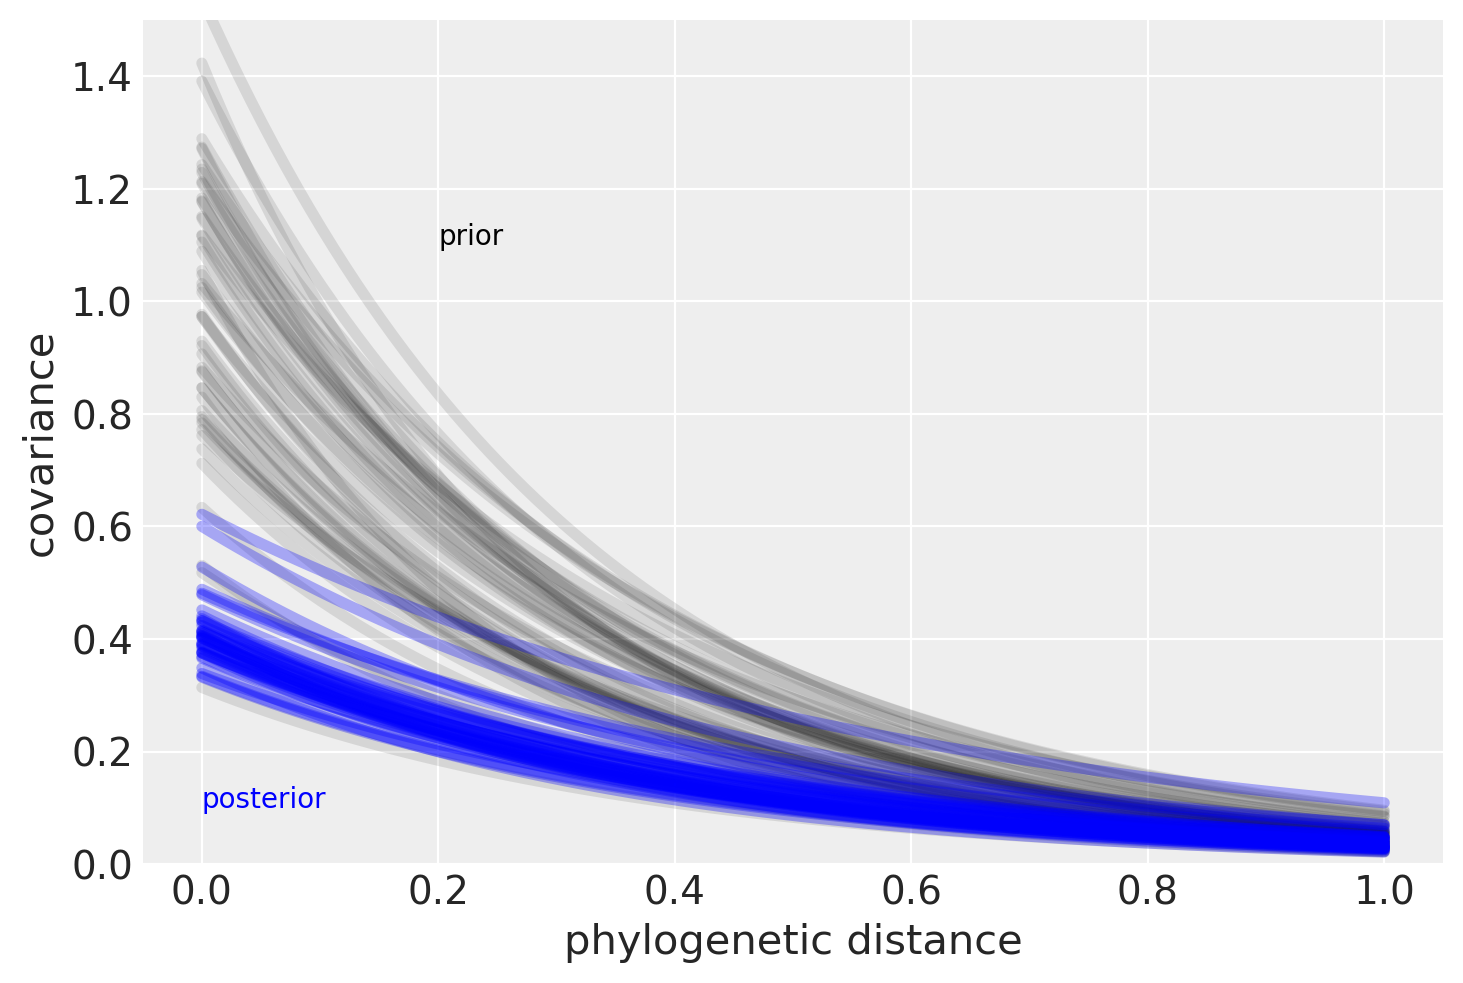

In [32]:
# posterior
d_seq = np.linspace(0, Dmat_ord.max(), 100)
post = trace_mB_OU.posterior.stack(sample=("chain", "draw"))
fig,ax=plt.subplots()

# prior 
prior_etasq = np.abs(pm.draw(pm.Normal.dist(1,0.25),50))
prior_rho = np.abs(pm.draw(pm.Normal.dist(3,0.25),50))
ax.plot(d_seq, (prior_etasq[:, None] * np.exp(-prior_rho[:, None] * d_seq)).T,lw=4,color="k",alpha=0.1,label="prior")

post_etasq = post["etasq"][::50].values[:, None]
post_rho = post["rho"][::50].values[:, None]
ax.plot(d_seq, (post_etasq * np.exp(-post_rho * d_seq)).T,lw=4,color="b",alpha=0.3,label="posterior")
ax.set(ylim=(0,1.5),xlabel="phylogenetic distance",ylabel="covariance")
ax.annotate("posterior",(0,0.1),color="b")
ax.annotate("prior",(0.2,1.1),color="k")
plt;

# slide 85

In [28]:
with pm.Model() as mBMG_OU:
    a = pm.Normal("a", 0.0, 1.0)
    bM = pm.Normal("bM",0,0.5)
    bG = pm.Normal("bG",0,0.5)
    etasq_ = pm.Normal("etasq_",1,0.25)
    rho_ = pm.Normal("rho_",3,0.25)
    etasq = pm.Deterministic("etasq",pm.math.abs(etasq_))
    rho = pm.Deterministic("rho",pm.math.abs(rho_))
    mu = a + bM*M + bG*G
    K = etasq * pt.exp(-rho*Dmat_ord) +pt.diag([.01]*N_spp)
    B = pm.MvNormal("B", mu=mu,cov=K,observed = B_)   
    trace_mBMG_OU = pm.sample(cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, bG, etasq_, rho_]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 436 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [30]:
az.summary(trace_mBMG_OU)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.065,0.075,-0.186,0.052,0.002,0.002,1546.0,1294.0,1.00
bM,0.834,0.030,0.789,0.884,0.001,0.000,1899.0,1433.0,1.00
bG,0.050,0.024,0.012,0.088,0.001,0.000,1976.0,1643.0,1.00
etasq_,0.001,0.035,-0.041,0.044,0.024,0.020,3.0,163.0,1.83
rho_,2.823,0.252,2.411,3.228,0.007,0.005,1380.0,1399.0,1.00
etasq,0.034,0.007,0.025,0.045,0.000,0.000,1329.0,1310.0,1.01
rho,2.823,0.252,2.411,3.228,0.007,0.005,1380.0,1399.0,1.00


# Slide 86

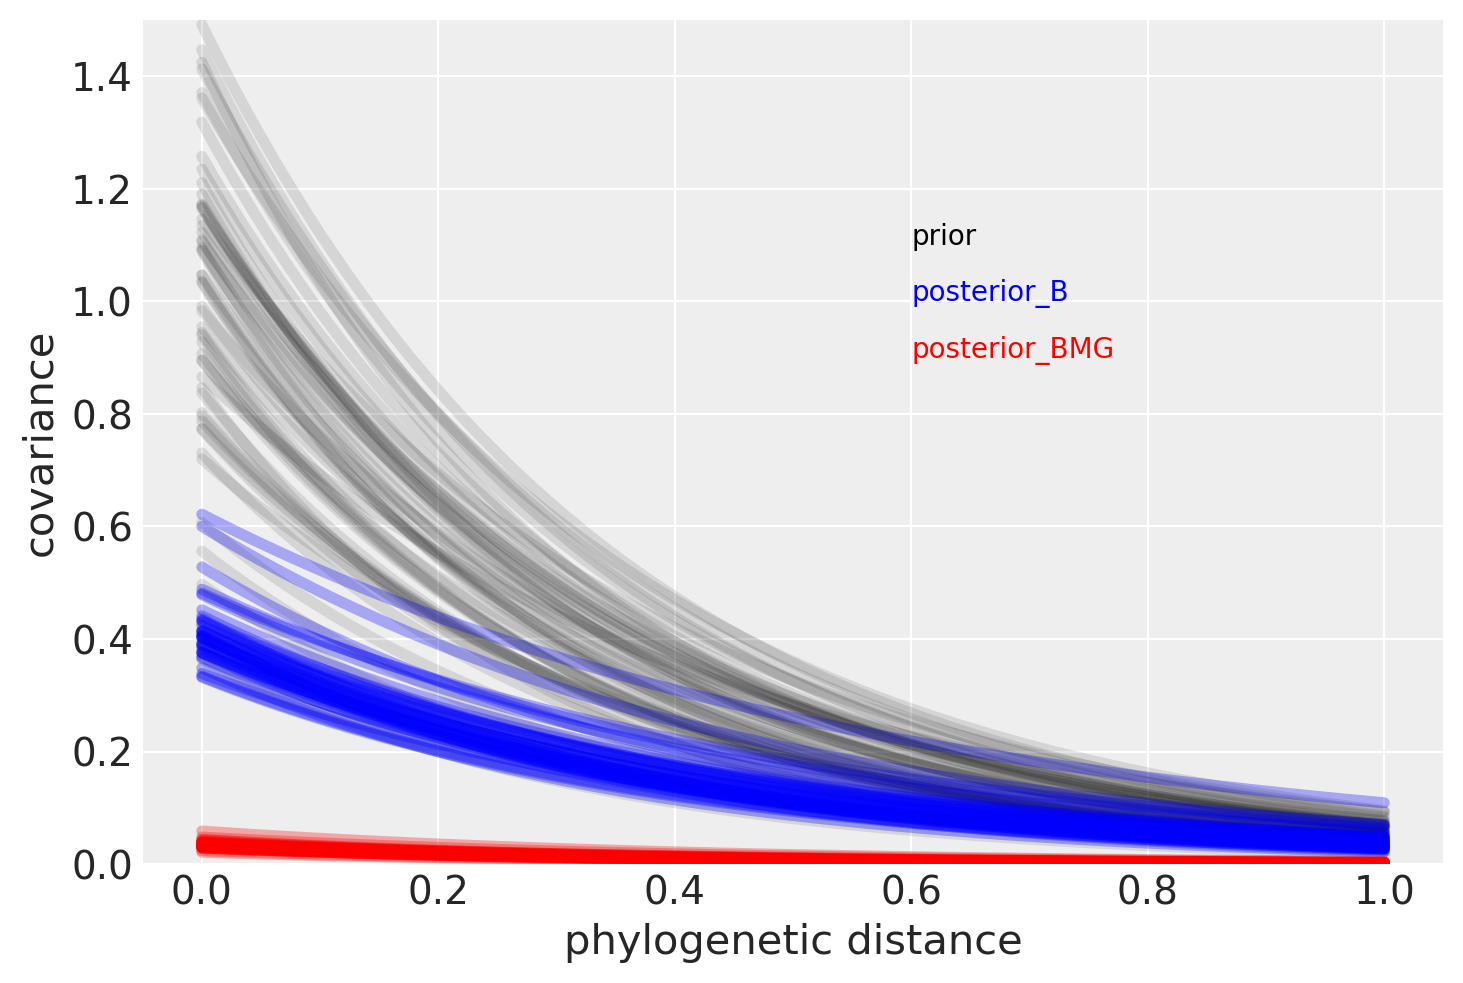

In [29]:
# posterior
d_seq = np.linspace(0, Dmat_ord.max(), 100)
post_B = trace_mB_OU.posterior.stack(sample=("chain","draw"))
post_BMG = trace_mBMG_OU.posterior.stack(sample=("chain", "draw"))
fig,ax=plt.subplots()

# prior 
prior_etasq = np.abs(pm.draw(pm.Normal.dist(1,0.25),50))
prior_rho = np.abs(pm.draw(pm.Normal.dist(3,0.25),50))
ax.plot(d_seq, (prior_etasq[:, None] * np.exp(-prior_rho[:, None] * d_seq)).T,lw=4,color="k",alpha=0.1,label="prior")

post_B_etasq = post_B["etasq"][::50].values[:, None]
post_B_rho = post_B["rho"][::50].values[:, None]

post_BMG_etasq = post_BMG["etasq"][::50].values[:, None]
post_BMG_rho = post_BMG["rho"][::50].values[:, None]

ax.plot(d_seq, (post_B_etasq * np.exp(-post_B_rho * d_seq)).T,lw=4,color="b",alpha=0.3)
ax.plot(d_seq,(post_BMG_etasq * np.exp(-post_BMG_rho * d_seq)).T,lw=4,color="r",alpha=0.3)
ax.set(ylim=(0,1.5),xlabel="phylogenetic distance",ylabel="covariance")


ax.annotate("prior",(0.6,1.1),color="k")
ax.annotate("posterior_B",(0.6,1),color="b")
ax.annotate("posterior_BMG",(0.6,0.9),color="r")
plt;

In [34]:
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Thu Jun 22 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.10.1
aeppl   : not installed
xarray  : 2023.5.0

numpy     : 1.24.3
matplotlib: 3.7.1
pandas    : 2.0.2
pytensor  : 2.10.1
pymc      : 5.1.2
scipy     : 1.10.1
arviz     : 0.15.1

Watermark: 2.3.1

